In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data

In [2]:

hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

TB_FIRE_1101_hits.root finished
TB_FIRE_1096_hits.root finished


<span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes

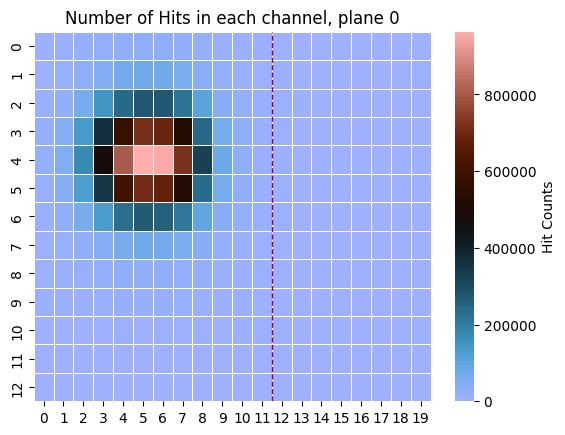

In [4]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 0)

In [5]:
# rf.hits_amount_colormap_single_plane(hit_data_1101, 7)

In [6]:
# rf.average_amp_colormap_single_plane(hit_data_1101, 7, cmap="managua")

<span style="font-family: arial; font-size:25px; color:pink">

Shower Evolution Throughout the Sensor

In [7]:
# rf.single_event_evolution_amp(hit_data_1101, 51, cmap="managua")

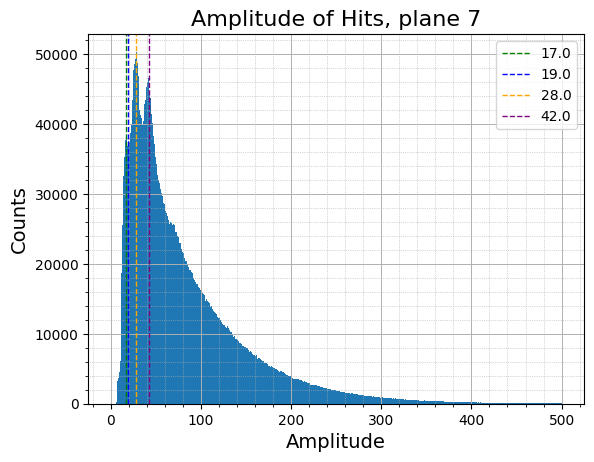

In [69]:
# plt.clf()   # Clear the current figure
# plt.close() # Close any open figures
# %matplotlib widget
rf.amp_histo_single_plane(hit_data_1101,7)

amount of hits in plane 0: 2154539
amount of hits in plane 1: 2267642
amount of hits in plane 2: 2299936
amount of hits in plane 3: 2305207
amount of hits in plane 4: 287522
amount of hits in plane 5: 2339654
amount of hits in plane 6: 2333522
amount of hits in plane 7: 2347161


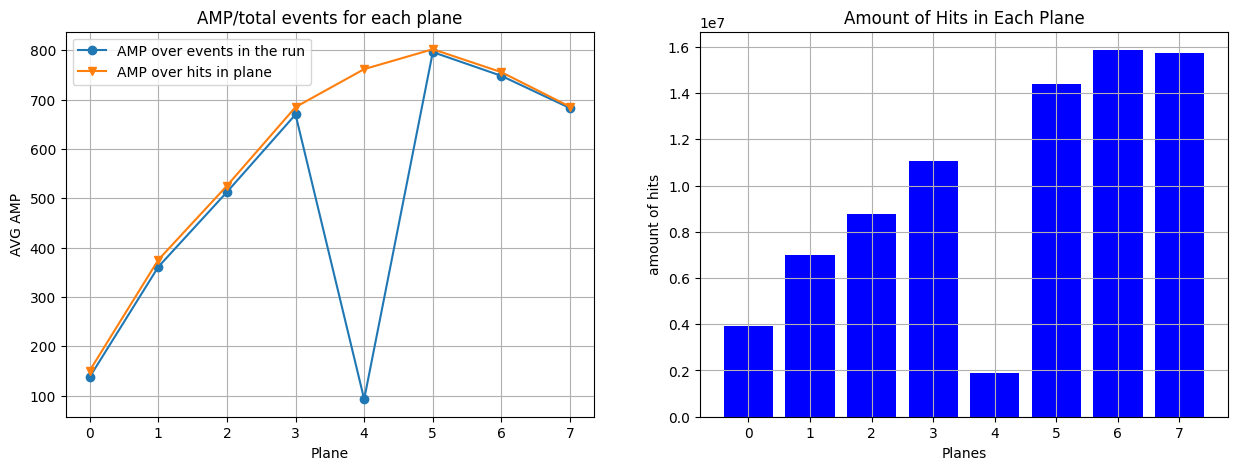

In [9]:
rf.average_amp_vs_plane(hit_data_1101)


amount of hits in plane 0: 442551
amount of hits in plane 1: 472210
amount of hits in plane 2: 481975
amount of hits in plane 3: 487737
amount of hits in plane 4: 493124
amount of hits in plane 5: 495561
amount of hits in plane 6: 495413
amount of hits in plane 7: 497180


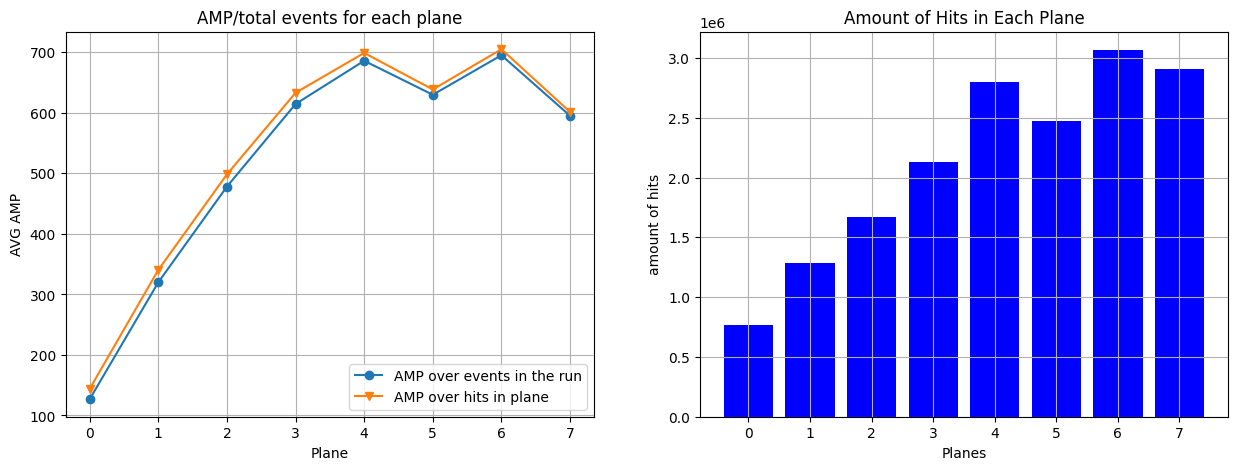

In [10]:
rf.average_amp_vs_plane(hit_data_1096)

In [11]:
# rf.single_event_evolution_amp(hit_data_1096, 9189, cmap = "managua")

total percentage of events: 100.0
100.0


c:\Users\bents\Desktop\Personal\work\Halina\F-Cal-TB-project\RA_funcs.py:494: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


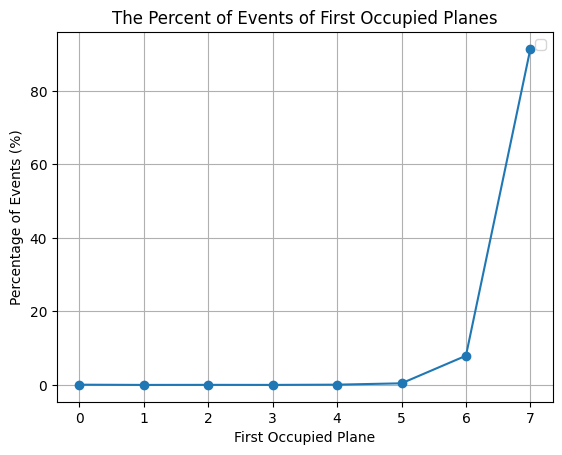

In [3]:
rf.plot_empty_first_planes(hit_data_1101)